In [1]:
from turc import TurcEstimator
import polars as pl

In [2]:
turc = TurcEstimator(
    caravan_path="/Users/nicolaslazaro/Desktop/CARAVAN_CLEAN_prod/train",
    basin_list_path="/Users/nicolaslazaro/Desktop/work/wb-project/turc/basin_id_files/tropical_test_basins.txt",
    batch_size=100
)

annual = turc.compute_annual()

annual.head(10)   

# Cast all negative Q_turc_mm to zero
annual = annual.with_columns(
    pl.when(pl.col("Q_turc_mm") < 0)
    .then(0)
    .otherwise(pl.col("Q_turc_mm"))
    .alias("Q_turc_mm")
)

# Remove all basins where Q_observed_mm is larger than annual_precip_mm
annual = annual.filter(pl.col("Q_observed_mm") <= pl.col("annual_precip_mm"))

print(annual)


shape: (3_180, 10)
┌─────────────┬──────┬────────────┬────────────┬───┬────────────┬────────────┬────────┬────────────┐
│ gauge_id    ┆ year ┆ annual_pre ┆ annual_tem ┆ … ┆ Q_turc_mm  ┆ Q_observed ┆ n_days ┆ n_valid_da │
│ ---         ┆ ---  ┆ cip_mm     ┆ p_c        ┆   ┆ ---        ┆ _mm        ┆ ---    ┆ ys         │
│ str         ┆ i64  ┆ ---        ┆ ---        ┆   ┆ f64        ┆ ---        ┆ i64    ┆ ---        │
│             ┆      ┆ f64        ┆ f64        ┆   ┆            ┆ f64        ┆        ┆ i64        │
╞═════════════╪══════╪════════════╪════════════╪═══╪════════════╪════════════╪════════╪════════════╡
│ camels_0816 ┆ 1986 ┆ 1077.39    ┆ 21.444548  ┆ … ┆ 213.957653 ┆ 91.26      ┆ 365    ┆ 365        │
│ 4600        ┆      ┆            ┆            ┆   ┆            ┆            ┆        ┆            │
│ camels_0816 ┆ 1989 ┆ 904.3      ┆ 20.96011   ┆ … ┆ 138.848307 ┆ 9.46       ┆ 365    ┆ 365        │
│ 4600        ┆      ┆            ┆            ┆   ┆            ┆       

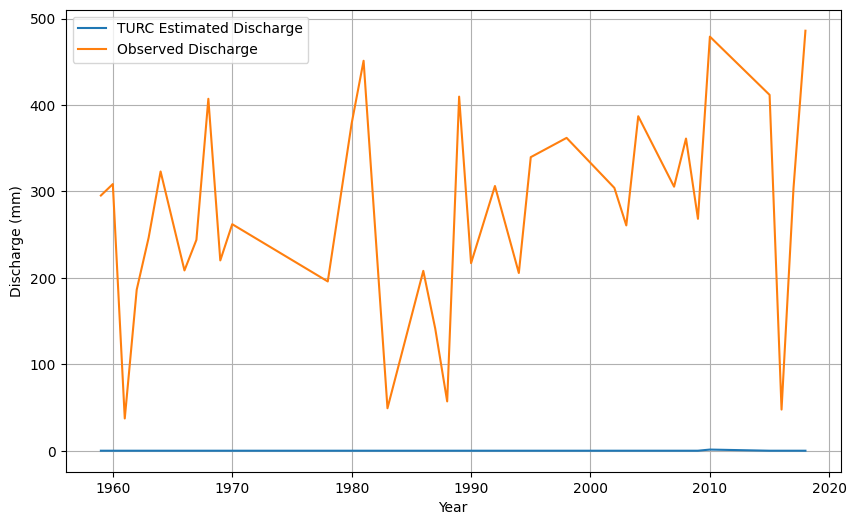

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

# Random basin choice
basin_id = "grdc_5109251"
basin_data = annual.filter(pl.col("gauge_id") == basin_id)

plt.figure(figsize=(10, 6))
sns.lineplot(data=basin_data.to_pandas(), x='year', y='Q_turc_mm', label='TURC Estimated Discharge')
sns.lineplot(data=basin_data.to_pandas(), x='year', y='Q_observed_mm', label='Observed Discharge')
plt.xlabel('Year')
plt.ylabel('Discharge (mm)')
plt.legend()
plt.grid(True)
plt.show()

